In [1]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

import glob
import os

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [3]:
path = r'data/'                     # use your path
all_files = glob.glob(os.path.join(path, "BTC.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

#df_from_each_file = (pd.read_csv(f) for f in all_files)
#concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)


In [4]:
data = pd.read_csv(all_files[0])
data = data.set_index('datetime')

print(data)
    

                            o         h         l         c             v
datetime                                                                 
2017-08-17 02:00:00   4261.48   4485.39   4200.74   4285.08    795.150377
2017-08-18 02:00:00   4285.08   4371.52   3938.77   4108.37   1199.888264
2017-08-19 02:00:00   4108.37   4184.69   3850.00   4139.98    381.309763
2017-08-20 02:00:00   4120.98   4211.08   4032.62   4086.29    467.083022
2017-08-21 02:00:00   4069.13   4119.62   3911.79   4016.00    691.743060
...                       ...       ...       ...       ...           ...
2021-11-26 01:00:00  58960.37  59150.00  53500.00  53726.53  65927.870660
2021-11-27 01:00:00  53723.72  55280.00  53610.00  54721.03  29716.999570
2021-11-28 01:00:00  54716.47  57445.05  53256.64  57274.88  36163.713700
2021-11-29 01:00:00  57274.89  58865.97  56666.67  57776.25  40125.280090
2021-11-30 01:00:00  57776.25  59176.99  55875.55  57332.40  45739.950150

[1567 rows x 5 columns]


In [5]:
def get_macd(price, slow, fast, smooth):
    #exponentialy weighted moving average
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'c':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

price_macd = get_macd(data['c'], 26, 12, 9)
price_macd

,macd,signal,hist
datetime,,,
2017-08-17 02:00:00,0.000000,0.000000,0.000000
2017-08-18 02:00:00,-14.096524,-2.819305,-11.277219
2017-08-19 02:00:00,-22.458570,-6.747158,-15.711412
2017-08-20 02:00:00,-33.037055,-12.005137,-21.031918
2017-08-21 02:00:00,-46.555731,-18.915256,-27.640475
...,...,...,...
2021-11-26 01:00:00,-1280.487579,-459.340322,-821.147257
2021-11-27 01:00:00,-1478.299939,-663.132245,-815.167694
2021-11-28 01:00:00,-1412.708484,-813.047493,-599.660991


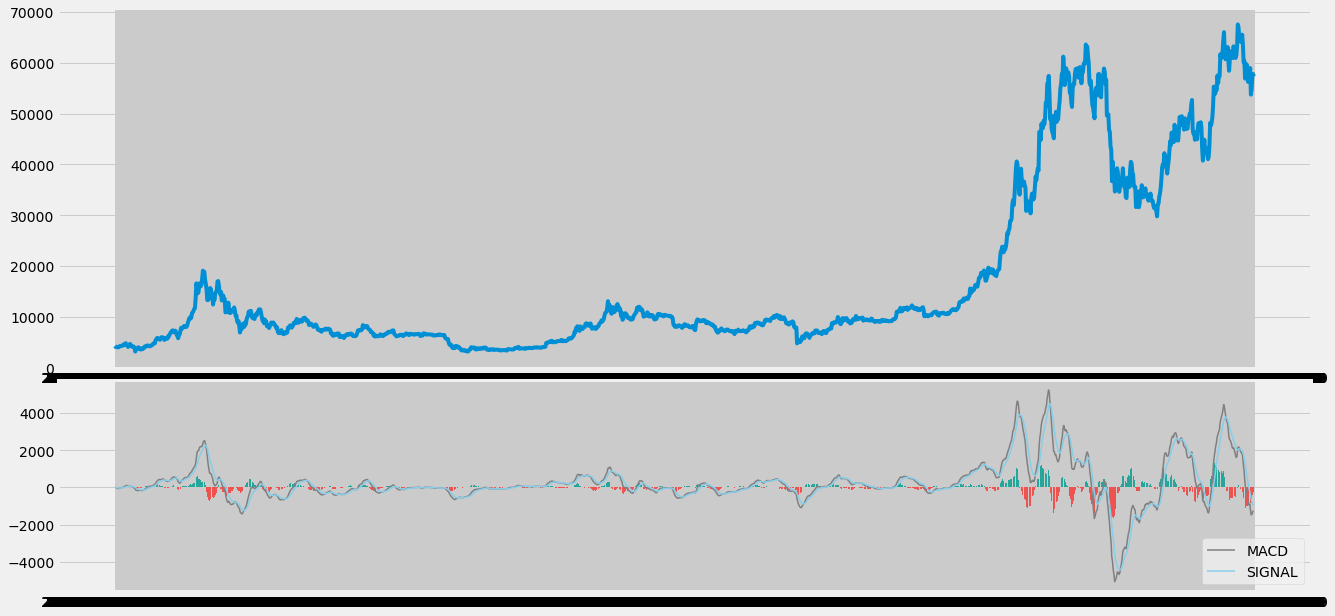

In [6]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(data['c'], price_macd['macd'], price_macd['signal'], price_macd['hist'])

In [7]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal


In [8]:
buy_price, sell_price, macd_signal = implement_macd_strategy(data['c'], price_macd)

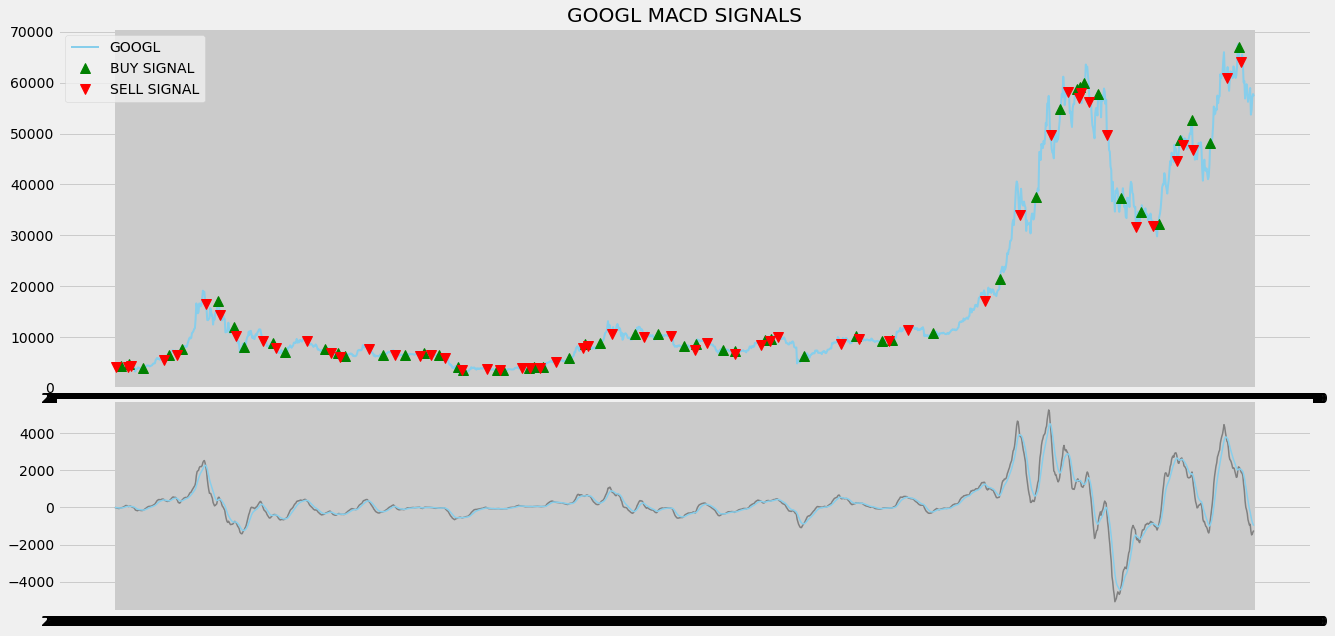

In [9]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(data['c'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(data.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
ax2.plot(price_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(price_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

In [17]:
path = r'data/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

should_buy = []
should_sell = []
for file in all_files:
    
    data = pd.read_csv(file)
    data = data.set_index('datetime')
    
    price_macd = get_macd(data['c'], 26, 12, 9)
    buy_price, sell_price, macd_signal = implement_macd_strategy(data['c'], price_macd)
    
    name = file.split('/', 1 )
    name = name[1].split('.', 1 )[0]
    
    if macd_signal[-1] == 1:
        should_buy.append(name)
    elif macd_signal[-1] == -1:
        should_sell.append(name)

In [18]:
print(should_buy)
print(should_sell)

['FTT', 'ETH', 'AAVE', 'UNI', 'KSM']
['ALICE']
